First, we need to import some libraries, which are required for creating the plots.

In [60]:
import os
import re
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(6,5)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('axes', unicode_minus=False)

def save_fig(ax, name, file_type="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()
    file_name = name + "." + file_type
    fig.savefig(os.path.join(file_name), bbox_inches='tight')
    # fig.clear()


In [61]:
results_dirs = ['results-aws', 'results-gcp', 'results-gcp2']
#results_dir = 'results-test'
config_dir = '.'
setups = pd.read_csv(os.path.join(config_dir, 'setups.csv'))

dfs = []
for results_dir in results_dirs:
    all_results = [(file, pd.read_csv(os.path.join(results_dir, file))) for file in os.listdir(results_dir) if file.endswith('_demand.csv')]
    dfs.append(pd.concat([result[1].assign(exp_id=int(re.search('^exp(\d+)_demand.csv$', result[0]).group(1)), results_dir=results_dir) for result in all_results]))

results = pd.concat(dfs)

demands = pd.merge(setups, results, on=['exp_id', 'results_dir'], how='left')
demands = demands[(demands['resources'] <= demands['max_resources']) | (demands['max_resources'].isnull()) | (demands['load'].isnull())]
demands = demands[(demands['vmtype'] == "e2-standard-4") | (demands['vmtype'] == "m5.xlarge")]
demands


,exp_id,results_dir,dummy,config_id,benchmark,source,engine,kafkas,cloud,vmtype,instances,max_resources,load,resources
0,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,100,1
1,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,200,2
2,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,300,2
10,6,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,3,5.0,300,3
11,6,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,3,5.0,400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,8894,results-gcp,True,11,uc1,http,samza,3,gcp,e2-standard-4,10,35.0,800,34
232,8895,results-gcp,True,11,uc1,http,samza,3,gcp,e2-standard-4,11,39.0,900,38
233,8896,results-gcp,True,11,uc1,http,samza,3,gcp,e2-standard-4,12,43.0,1000,42
234,8897,results-gcp,True,11,uc1,http,samza,3,gcp,e2-standard-4,13,47.0,1100,46


Compute GKE Autopilot costs:

In [62]:
resources = demands[(demands['cloud'] == "gcp") & (demands['source'] == "http") & (demands['engine'] == "flink")]
min_resources = resources.loc[resources.groupby(['config_id','load'])['resources'].idxmin()]
min_resources['cloud'] = "gcp-autopilot"
min_resources['config_id'] = min_resources['config_id'] + 100 # Placeholder for GKE Autopilot
demands = demands.append(min_resources, ignore_index=True)

In [63]:
# UC1, HTTP
# costs = instances * instance_cost + load * firestore_write_cost
# UC3, Pub/Sub
# costs = instances * instance_cost + load * pubsub_message_cost + load * firestore_write_cost
# UC3, HTTP
# costs = instances * instance_cost
# UC3, Pub/Sub
# costs = instances * instance_cost + load * pubsub_message_cost

vm_cost_per_hour = {
    'e2-standard-4': 0.172668,
    'e2-standard-2': 0.086334,
    'n1-standard-1': 0.04749975,
    'm5.xlarge': 0.23
}
message_size_bytes = 560 # approx.
gke_cluster_fee = 0.1 # same for eks and gke
firestore_write_cost_per_hour = (3600/100000) * 0.117
dynamodb_write_cost_per_hour = (3600/1000000) * 1.525
pubsub_cost_per_message = (40/(1024*1024*1024*1024))*1000*3600
gcp_lb_cost_per_hour = 0.03
gcp_lb_cost_per_message = 0.01/(1000*1000*1000) * message_size_bytes
aws_lb_cost_per_hour = 0.03
aws_lb_cost_per_message = 0.008/(1000*1000*1000) * message_size_bytes
autopilot_vcpu_cost_per_hour = 0.0573
autopilot_gb_cost_per_hour = 0.0063421

def costs(benchmark, source, engine, cloud, vmtype, instances, load, resources):
    firestore_write_cost = 0
    firestore_read_cost = 0
    pubsub_cost = 0
    vm_cost = 0
    if engine == 'dataflow':
        vm_cost = vm_cost_per_hour[vmtype] * resources
    elif cloud == 'gcp-autopilot':
        vm_cost = (
            + 0.25 * autopilot_vcpu_cost_per_hour + 1 * autopilot_gb_cost_per_hour # Prometheus Operator
            + 0.25 * autopilot_vcpu_cost_per_hour + 0.5 * autopilot_gb_cost_per_hour # Prometheus
            + 0.25 * autopilot_vcpu_cost_per_hour + 0.5 * autopilot_gb_cost_per_hour # Grafana
            + 0.25 * autopilot_vcpu_cost_per_hour + 1 * autopilot_gb_cost_per_hour # Strimzi Cluster Operator
            + 0.25 * autopilot_vcpu_cost_per_hour + 0.5 * autopilot_gb_cost_per_hour # Strimzi Entity Operator
            + 3 * (1 * autopilot_vcpu_cost_per_hour + 1 * autopilot_gb_cost_per_hour) # Kafka
            + 3 * (0.25 * autopilot_vcpu_cost_per_hour + 0.5 * autopilot_gb_cost_per_hour) # ZooKeeper
            + 0.25 * autopilot_vcpu_cost_per_hour + 0.5 * autopilot_gb_cost_per_hour # Kafka Exporter
            + 0.25 * autopilot_vcpu_cost_per_hour + 1 * autopilot_gb_cost_per_hour # Schema Registry
            + 0.25 * autopilot_vcpu_cost_per_hour + 0.5 * autopilot_gb_cost_per_hour # Load Generator
            + 1 * autopilot_vcpu_cost_per_hour + 1 * autopilot_gb_cost_per_hour # HTTP Bridge
            + 0.25 * autopilot_vcpu_cost_per_hour + 1 * autopilot_gb_cost_per_hour # Flink Jobmanager
            + resources * (1 * autopilot_vcpu_cost_per_hour + 1 * autopilot_gb_cost_per_hour) # Flink Taskmanager
            )
    else:
        vm_cost = vm_cost_per_hour[vmtype] * instances
    if benchmark == 'uc1':
        if cloud == 'gcp' or cloud == 'gcp-autopilot':
            firestore_write_cost = firestore_write_cost_per_hour * load
        elif cloud == 'aws':
            firestore_write_cost = dynamodb_write_cost_per_hour * load
    if source == 'pubsub':
        pubsub_cost = pubsub_cost_per_message * load
    else:
        if cloud == 'gcp' or cloud == 'gcp-autopilot':
            pubsub_cost = gcp_lb_cost_per_hour + (gcp_lb_cost_per_message * load) # cost for load balancer
        elif cloud == 'aws':
            pubsub_cost = aws_lb_cost_per_hour + (aws_lb_cost_per_message * load) # cost for load balancer
    return pd.Series([
        0 if engine == "dataflow" else gke_cluster_fee,
        vm_cost,
        firestore_write_cost,
        firestore_read_cost,
        pubsub_cost,
    ])

demands[['cluster_fee', 'vm_cost', 'fs_write_cost', 'fs_read_cost', 'pubsub_cost']] = demands.apply(lambda row: costs(row['benchmark'], row['source'], row['engine'], row['cloud'], row['vmtype'], row['instances'], row['load'], row['resources']), axis=1)
demands['total_cost'] = demands.apply(lambda row: reduce(lambda x, y: x + y, row[['cluster_fee', 'vm_cost', 'fs_write_cost', 'fs_read_cost', 'pubsub_cost']]), axis=1)
demands


,exp_id,results_dir,dummy,config_id,benchmark,source,engine,kafkas,cloud,vmtype,instances,max_resources,load,resources,cluster_fee,vm_cost,fs_write_cost,fs_read_cost,pubsub_cost,total_cost
0,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,100,1,0.1,0.345336,0.0000,0.0,0.030001,0.475337
1,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,200,2,0.1,0.345336,0.0000,0.0,0.030001,0.475337
2,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,300,2,0.1,0.345336,0.0000,0.0,0.030002,0.475338
3,6,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,3,5.0,300,3,0.1,0.518004,0.0000,0.0,0.030002,0.648006
4,6,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,3,5.0,400,3,0.1,0.518004,0.0000,0.0,0.030002,0.648006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,14,results-gcp2,False,103,uc1,http,flink,3,gcp-autopilot,e2-standard-4,3,6.0,800,4,0.1,0.731774,3.3696,0.0,0.030004,4.231378
168,16,results-gcp2,False,103,uc1,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,900,7,0.1,0.922700,3.7908,0.0,0.030005,4.843505
169,16,results-gcp2,False,103,uc1,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,1000,8,0.1,0.986342,4.2120,0.0,0.030006,5.328348
170,16,results-gcp2,False,103,uc1,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,1100,8,0.1,0.986342,4.6332,0.0,0.030006,5.749548


Get minimal cost per load intensity

In [64]:
min_costs = demands.loc[demands.groupby(['config_id','load'])['total_cost'].idxmin()]
min_costs

,exp_id,results_dir,dummy,config_id,benchmark,source,engine,kafkas,cloud,vmtype,instances,max_resources,load,resources,cluster_fee,vm_cost,fs_write_cost,fs_read_cost,pubsub_cost,total_cost
0,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,100,1,0.1,0.345336,0.0000,0.0,0.030001,0.475337
1,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,200,2,0.1,0.345336,0.0000,0.0,0.030001,0.475337
2,5,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,2,2.0,300,2,0.1,0.345336,0.0000,0.0,0.030002,0.475338
4,6,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,3,5.0,400,3,0.1,0.518004,0.0000,0.0,0.030002,0.648006
5,6,results-gcp2,False,1,uc3,http,flink,3,gcp,e2-standard-4,3,5.0,500,4,0.1,0.518004,0.0000,0.0,0.030003,0.648007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,14,results-gcp2,False,103,uc1,http,flink,3,gcp-autopilot,e2-standard-4,3,6.0,800,4,0.1,0.731774,3.3696,0.0,0.030004,4.231378
168,16,results-gcp2,False,103,uc1,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,900,7,0.1,0.922700,3.7908,0.0,0.030005,4.843505
169,16,results-gcp2,False,103,uc1,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,1000,8,0.1,0.986342,4.2120,0.0,0.030006,5.328348
170,16,results-gcp2,False,103,uc1,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,1100,8,0.1,0.986342,4.6332,0.0,0.030006,5.749548


In [65]:
# add a column with 0 load to make the graphs look nicer

x = min_costs[min_costs["load"] == 100].copy()
x["load"] = 0
# be sure to update fs costs or this doesnt make any sense
x["total_cost"] = x["total_cost"] - x["fs_write_cost"] - x["fs_read_cost"] - x["pubsub_cost"]
x["fs_write_cost"] = 0
x["fs_read_cost"] = 0
x["pubsub_cost"] = 0
min_costs = min_costs.append(x)
min_costs.reset_index(drop=True, inplace=True)
min_costs.sort_values(by=["benchmark", "config_id", "load"], inplace=True)
min_costs

,exp_id,results_dir,dummy,config_id,benchmark,source,engine,kafkas,cloud,vmtype,instances,max_resources,load,resources,cluster_fee,vm_cost,fs_write_cost,fs_read_cost,pubsub_cost,total_cost
145,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,0,1,0.1,0.345336,0.0000,0.0,0.000000,0.445336
12,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,100,1,0.1,0.345336,0.4212,0.0,0.030001,0.896537
13,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,200,2,0.1,0.345336,0.8424,0.0,0.030001,1.317737
14,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,300,2,0.1,0.345336,1.2636,0.0,0.030002,1.738938
15,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,400,3,0.1,0.345336,1.6848,0.0,0.030002,2.160138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,7,results-gcp2,False,101,uc3,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,800,6,0.1,0.859058,0.0000,0.0,0.030004,0.989062
128,7,results-gcp2,False,101,uc3,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,900,6,0.1,0.859058,0.0000,0.0,0.030005,0.989063
129,7,results-gcp2,False,101,uc3,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,1000,7,0.1,0.922700,0.0000,0.0,0.030006,1.052706
130,7,results-gcp2,False,101,uc3,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,1100,8,0.1,0.986342,0.0000,0.0,0.030006,1.116348


Select some SUT/configs by their IDs and plot everything:

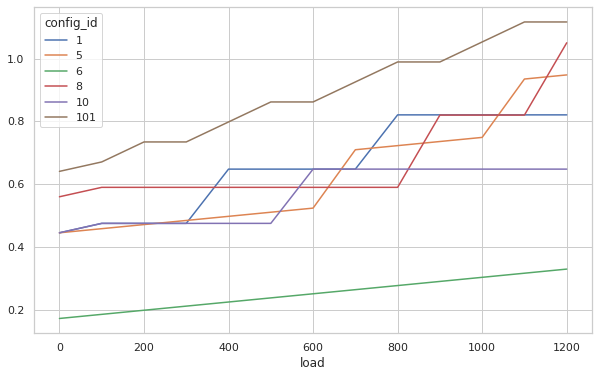

In [66]:
config_ids = [1, 5, 6, 8, 10, 101] # set config_ids to be plotted here
#config_ids = [3, 4, 7, 9, 11, 103]

costs_per_load = min_costs.pivot(index='load', columns='config_id', values='total_cost').reset_index()
costs_per_load.plot(x='load', y=config_ids, kind='line', figsize=(10,6))


In [67]:
min_costs.to_csv('streaming-results.csv', index=False)

In [68]:
min_costs


,exp_id,results_dir,dummy,config_id,benchmark,source,engine,kafkas,cloud,vmtype,instances,max_resources,load,resources,cluster_fee,vm_cost,fs_write_cost,fs_read_cost,pubsub_cost,total_cost
145,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,0,1,0.1,0.345336,0.0000,0.0,0.000000,0.445336
12,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,100,1,0.1,0.345336,0.4212,0.0,0.030001,0.896537
13,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,200,2,0.1,0.345336,0.8424,0.0,0.030001,1.317737
14,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,300,2,0.1,0.345336,1.2636,0.0,0.030002,1.738938
15,9,results-gcp2,False,3,uc1,http,flink,3,gcp,e2-standard-4,2,3.0,400,3,0.1,0.345336,1.6848,0.0,0.030002,2.160138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,7,results-gcp2,False,101,uc3,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,800,6,0.1,0.859058,0.0000,0.0,0.030004,0.989062
128,7,results-gcp2,False,101,uc3,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,900,6,0.1,0.859058,0.0000,0.0,0.030005,0.989063
129,7,results-gcp2,False,101,uc3,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,1000,7,0.1,0.922700,0.0000,0.0,0.030006,1.052706
130,7,results-gcp2,False,101,uc3,http,flink,3,gcp-autopilot,e2-standard-4,4,NaN,1100,8,0.1,0.986342,0.0000,0.0,0.030006,1.116348


In [69]:
# PubSub costs at different load intensities
min_costs['pubsub_cost_rel'] = min_costs['pubsub_cost'] / min_costs['total_cost']
uc1_pubsub_rel_cost_100 = min_costs[(min_costs['benchmark'] == 'uc1') & (min_costs['engine'] == 'flink') & (min_costs['source'] == 'pubsub') & (min_costs['load'] == 100)].iloc[0]['pubsub_cost_rel']
uc1_pubsub_rel_cost_1000 = min_costs[(min_costs['benchmark'] == 'uc1') & (min_costs['engine'] == 'flink') & (min_costs['source'] == 'pubsub') & (min_costs['load'] == 1000)].iloc[0]['pubsub_cost_rel']
uc3_pubsub_rel_cost_100 = min_costs[(min_costs['benchmark'] == 'uc3') & (min_costs['engine'] == 'flink') & (min_costs['source'] == 'pubsub') & (min_costs['load'] == 100)].iloc[0]['pubsub_cost_rel']
uc3_pubsub_rel_cost_1000 = min_costs[(min_costs['benchmark'] == 'uc3') & (min_costs['engine'] == 'flink') & (min_costs['source'] == 'pubsub') & (min_costs['load'] == 1000)].iloc[0]['pubsub_cost_rel']

print(f'Relative Pub/Sub cost increase from {uc1_pubsub_rel_cost_100*100:.1f}% to {uc1_pubsub_rel_cost_1000*100:.1f}%.')
print(f'Relative Pub/Sub cost increase from {uc3_pubsub_rel_cost_100*100:.1f}% to {uc3_pubsub_rel_cost_1000*100:.1f}%.')

#uc1_pubsub_rel_cost_100

Relative Pub/Sub cost increase from 1.5% to 2.6%.
Relative Pub/Sub cost increase from 2.9% to 17.5%.


In [70]:
# All request costs are in USD/hour

key = ['benchmark', 'engine', 'source', 'cloud', 'config_id']
min_costs_per_load = min_costs[min_costs['load'] != 0]
min_costs_per_load = min_costs_per_load[min_costs_per_load['load'] <= 1200] # TODO temporary to ensure same loads
min_costs_per_load['total_cost_per_request'] = min_costs_per_load.apply(lambda row: row['total_cost'] / row['load'], axis=1)
min_costs_per_load['cluster_fee_per_request'] = min_costs_per_load.apply(lambda row: row['cluster_fee'] / row['load'], axis=1)
min_costs_per_load['vm_cost_per_request'] = min_costs_per_load.apply(lambda row: row['vm_cost'] / row['load'], axis=1)
min_costs_per_load['fs_write_cost_per_request'] = min_costs_per_load.apply(lambda row: row['fs_write_cost'] / row['load'], axis=1)
min_costs_per_load['pubsub_cost_per_request'] = min_costs_per_load.apply(lambda row: row['pubsub_cost'] / row['load'], axis=1)
avg_min_costs_per_load = min_costs_per_load.groupby(key).agg({
    'total_cost_per_request': 'mean',
    'cluster_fee_per_request': 'mean',
    'vm_cost_per_request': 'mean',
    'fs_write_cost_per_request': 'mean',
    'pubsub_cost_per_request': 'mean',
    'load': 'mean'
    }).reset_index().sort_values(by=key)
avg_min_costs_per_load

,benchmark,engine,source,cloud,config_id,total_cost_per_request,cluster_fee_per_request,vm_cost_per_request,fs_write_cost_per_request,pubsub_cost_per_request,load
0,uc1,dataflow,pubsub,gcp,7,0.004875,0.000000,0.000532,0.004212,0.000131,650
1,uc1,flink,http,aws,9,0.007016,0.000259,0.001190,0.005490,0.000078,650
2,uc1,flink,http,gcp,3,0.005643,0.000259,0.001095,0.004212,0.000078,650
3,uc1,flink,http,gcp-autopilot,103,0.006256,0.000259,0.001707,0.004212,0.000078,650
4,uc1,flink,pubsub,gcp,4,0.005693,0.000259,0.001092,0.004212,0.000131,650
5,uc1,samza,http,gcp,11,0.007168,0.000259,0.002620,0.004212,0.000078,650
6,uc3,dataflow,pubsub,gcp,6,0.000577,0.000000,0.000447,0.000000,0.000131,650
7,uc3,flink,http,aws,8,0.001616,0.000259,0.001279,0.000000,0.000078,650
8,uc3,flink,http,gcp,1,0.001485,0.000259,0.001149,0.000000,0.000078,650
9,uc3,flink,http,gcp-autopilot,101,0.002053,0.000259,0.001717,0.000000,0.000078,650


In [71]:
flink_uc1_costs = avg_min_costs_per_load[(avg_min_costs_per_load['benchmark'] == 'uc1') & (avg_min_costs_per_load['engine'] == 'flink') & (avg_min_costs_per_load['cloud'] == 'gcp') & (avg_min_costs_per_load['source'] == 'pubsub')].iloc[0]['total_cost_per_request']
dataflow_uc1_costs = avg_min_costs_per_load[(avg_min_costs_per_load['benchmark'] == 'uc1') & (avg_min_costs_per_load['engine'] == 'dataflow') & (avg_min_costs_per_load['cloud'] == 'gcp')& (avg_min_costs_per_load['source'] == 'pubsub')].iloc[0]['total_cost_per_request']

flink_uc2_costs = avg_min_costs_per_load[(avg_min_costs_per_load['benchmark'] == 'uc3') & (avg_min_costs_per_load['engine'] == 'flink') & (avg_min_costs_per_load['cloud'] == 'gcp') & (avg_min_costs_per_load['source'] == 'pubsub')].iloc[0]['total_cost_per_request']
dataflow_uc2_costs = avg_min_costs_per_load[(avg_min_costs_per_load['benchmark'] == 'uc3') & (avg_min_costs_per_load['engine'] == 'dataflow') & (avg_min_costs_per_load['cloud'] == 'gcp')& (avg_min_costs_per_load['source'] == 'pubsub')].iloc[0]['total_cost_per_request']

print(f"Dataflow is {dataflow_uc1_costs/flink_uc1_costs*100:.1f}% of the costs for Flink for UC1.")
print(f"Dataflow is {dataflow_uc2_costs/flink_uc2_costs*100:.1f}% of the costs for Flink for UC2.")

Dataflow is 85.6% of the costs for Flink for UC1.
Dataflow is 41.2% of the costs for Flink for UC2.


In [72]:
gke_uc1_costs = avg_min_costs_per_load[(avg_min_costs_per_load['benchmark'] == 'uc1') & (avg_min_costs_per_load['engine'] == 'flink') & (avg_min_costs_per_load['cloud'] == 'gcp') & (avg_min_costs_per_load['source'] == 'http')].iloc[0]['total_cost_per_request']
eks_uc1_costs = avg_min_costs_per_load[(avg_min_costs_per_load['benchmark'] == 'uc1') & (avg_min_costs_per_load['engine'] == 'flink') & (avg_min_costs_per_load['cloud'] == 'aws')& (avg_min_costs_per_load['source'] == 'http')].iloc[0]['total_cost_per_request']
gke_uc2_costs = avg_min_costs_per_load[(avg_min_costs_per_load['benchmark'] == 'uc3') & (avg_min_costs_per_load['engine'] == 'flink') & (avg_min_costs_per_load['cloud'] == 'gcp') & (avg_min_costs_per_load['source'] == 'http')].iloc[0]['total_cost_per_request']
eks_uc2_costs = avg_min_costs_per_load[(avg_min_costs_per_load['benchmark'] == 'uc3') & (avg_min_costs_per_load['engine'] == 'flink') & (avg_min_costs_per_load['cloud'] == 'aws')& (avg_min_costs_per_load['source'] == 'http')].iloc[0]['total_cost_per_request']

print(f"EKS is {eks_uc1_costs/gke_uc1_costs*100:.1f}% of the costs of GKE for UC1.")
print(f"EKS is {eks_uc2_costs/gke_uc2_costs*100:.1f}% of the costs of GKE for UC2.")

EKS is 124.3% of the costs of GKE for UC1.
EKS is 108.8% of the costs of GKE for UC2.


In [73]:
faas_df = pd.DataFrame()

# rename types:
ts = {
    "pubsub_cost_per_request": "Transport",
    "vm_cost_per_request": "Instances",
    "fs_write_cost_per_request": "DB Write",
    "cluster_fee_per_request": "Cluster",
}

# rename platforms:
ps = {
    "aws": "AWS",
    "gcp": "GCP",
}

# rename ucs:
us = {
    "uc1": "UC1",
    "uc3": "UC2",
}

combinations = {
    3: "GCP",
    4: "GCP\nPub/Sub",
    9: "AWS",
    11: "GCP\nSamza",
    7: "GCP\nDataflow",
    103: "GCP\nAutop.",
    1: "GCP",
    5: "GCP\nPub/Sub",
    8: "AWS",
    10: "GCP\nSamza",
    6: "GCP\nDataflow",
    101: "GCP\nAutop.",
}


for c in combinations.keys():
    for t in ts:
        faas_df = faas_df.append(pd.Series({
            "Platform": combinations[c],
            "UC": us[avg_min_costs_per_load[(avg_min_costs_per_load["config_id"] == c)]['benchmark'].values[0]],
            "Cost": avg_min_costs_per_load[(avg_min_costs_per_load["config_id"] == c)][t].values[0] / 3600,
            "Cost Type": ts[t]
        }), ignore_index=True)

faas_df

,Cost,Cost Type,Platform,UC
0,2.155163e-08,Transport,GCP,UC1
1,3.042335e-07,Instances,GCP,UC1
2,1.170000e-06,DB Write,GCP,UC1
3,7.183358e-08,Cluster,GCP,UC1
4,3.637979e-08,Transport,GCP\nPub/Sub,UC1
5,3.032040e-07,Instances,GCP\nPub/Sub,UC1
6,1.170000e-06,DB Write,GCP\nPub/Sub,UC1
7,7.183358e-08,Cluster,GCP\nPub/Sub,UC1
8,2.155132e-08,Transport,AWS,UC1
9,3.304345e-07,Instances,AWS,UC1


In [74]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [ ]:
cmap = sns.color_palette(as_cmap=True)
cmap_bright = sns.color_palette("pastel", as_cmap=True)
print(f"blue: {matplotlib.colors.to_hex(cmap[0])}")
print(f"orange: {matplotlib.colors.to_hex(cmap[1])}")
print(f"green: {matplotlib.colors.to_hex(cmap[2])}")
print(f"red: {matplotlib.colors.to_hex(cmap[3])}")

print(f"blue pastel: {matplotlib.colors.to_hex(cmap_bright[0])}")
print(f"orange pastel: {matplotlib.colors.to_hex(cmap_bright[1])}")
print(f"green pastel: {matplotlib.colors.to_hex(cmap_bright[2])}")
print(f"red pastel: {matplotlib.colors.to_hex(cmap_bright[3])}")

In [ ]:
# alternative:
# keep colors exactly as in FaaS
cmap2 = sns.color_palette(as_cmap=True)
cmap2 = [cmap2[4], cmap2[9], cmap2[3], cmap2[8]]

In [ ]:
from matplotlib.ticker import (MultipleLocator)

ratio = 10
f, (stream_uc1_out, stream_uc1) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, ratio]}) # 'hspace':0.1 <- breaks figsize
stream_uc1 = sns.histplot(faas_df[faas_df["UC"] == "UC1"], x='Platform', hue='Cost Type', weights='Cost', multiple='stack', shrink=0.8, alpha=1, ax=stream_uc1, palette=cmap2)
stream_uc1_out = sns.histplot(faas_df[faas_df["UC"] == "UC1"], x='Platform', hue='Cost Type', weights='Cost', multiple='stack', shrink=0.8, alpha=1, ax=stream_uc1_out, palette=cmap2)

stream_uc1_out.set_ylabel('')
stream_uc1.set_ylabel('Avg. Cost per Request ($)')
# faas_uc1.set_xlabel('UC1')
#stream_uc1.get_figure().set_size_inches(6, 4.2)
f.set_size_inches(6, 4.2)

range = 0.00000164
stream_uc1.set(ylim=(0, range))
upper = 0.01840166
stream_uc1_out.set(ylim=(upper-(range/ratio), upper))
stream_uc1_out.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6), useOffset=False)
stream_uc1_out.yaxis.set_major_locator(MultipleLocator(.0000002))
stream_uc1.yaxis.set_major_locator(MultipleLocator(.0000002))
#stream_uc1_out.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
stream_uc1.yaxis.offsetText.set_visible(False)
stream_uc1.spines["top"].set_visible(False)
stream_uc1_out.spines["bottom"].set_visible(False)

stream_uc1_out.get_legend().remove()
stream_uc1.legend_.set_bbox_to_anchor((1, 0.85)) # Adjust this as needed

# Add diagonal lines
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=stream_uc1_out.transAxes, color="#CCCCCC", clip_on=False)
stream_uc1_out.plot((-d, +d), (-d*ratio, +d*ratio), **kwargs)        # top-left diagonal
stream_uc1_out.plot((1 - d, 1 + d), (-d*ratio, +d*ratio), **kwargs)  # top-right diagonal

kwargs.update(transform=stream_uc1.transAxes)  # switch to the bottom axes
stream_uc1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
stream_uc1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#stream_uc1.legend_.set_bbox_to_anchor((1, 0.75))
#save_fig_plain(f, "uc1-streaming-share")

In [ ]:
stream_uc1 = sns.histplot(faas_df[faas_df["UC"] == "UC1"], x='Platform', hue='Cost Type', weights='Cost', multiple='stack', shrink=0.8, alpha=1, palette=cmap2)
stream_uc1.set_ylabel('Avg. Cost per Request ($)')
# faas_uc1.set_xlabel('UC1')
stream_uc1.get_figure().set_size_inches(6, 3.5)
#stream_uc1.set(ylim=(0, 0.000002))
stream_uc1.legend_.set_bbox_to_anchor((1, 0.80))
save_fig(stream_uc1, "uc1-streaming-share")

In [ ]:
stream_uc2 = sns.histplot(faas_df[faas_df["UC"] == "UC2"], x='Platform', hue='Cost Type', weights='Cost', multiple='stack', shrink=0.8, alpha=1, palette=cmap2)
stream_uc2.set_ylabel('Avg. Cost per Request ($)')
# faas_uc1.set_xlabel('UC1')
stream_uc2.get_figure().set_size_inches(6, 3.5)
stream_uc2.legend_.set_bbox_to_anchor((1, 0.80))
save_fig(stream_uc2, "uc2-streaming-share")